[<img src="https://user-images.githubusercontent.com/79705081/109483674-d3eea600-7a7f-11eb-9a25-58c50da4cde9.png">](http://edenlibrary.ai/)

# Plant Segmentation-Background Removal-2

## Instructions
1. Clone the repository.
2. Download the necessary datasets from Eden Repository:
  1. Broccoli-08/SEP/2019-v1
3. Unzip dataset files and remove the zip files.
4. Create a folder called 'eden_data'.
5. Move the unzipped datasets into this folder.
6. The resulting directory structure should be:
    * eden_library_notebooks/
       * image_preprocessing/
          * plant_segmentation-background_removal-2.ipynb
       * eden_data/
          * Broccoli-080919-Healthy-zz-V1-20210225102111
7. Install notebook dependencies by running:
    <pre><code>conda env create -f eden_transfer_learning.yml</code></pre>
8. Open the notebook: jupyter notebook
9. Run the code

**Note:** If you find any issues while executing the notebook, don't hesitate to open an issue on Github. We will reply you as soon as possible.

## Background (Go to [Biobliography](#references) for more details)

In order to improve the performance of a deep-learning-based system, many times a pre-processing step known as background removal is applied. This technique is supposed to remove as much noise/background from the image, making the object of study appearing as the main part of the picture. Additionally, background removal is not only useful for improving the performance of the deep neural network, but also for reducing <a href="https://en.wikipedia.org/wiki/Overfitting">overffing</a>.

In **agriculture**, several works have made use of background removal techniques for achieving a better performance (**Mohanty et al., 2016; McCool et al., 2017; Milioto et al., 2017; Espejo-Garcia et al., 2020**). In this notebook, we are gonna use a specific technique, where the HSV color-space representation (see Figure) will provide us with a better model for separating by thresholding the background and foreground parts of the image.

[<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/33/HSV_color_solid_cylinder_saturation_gray.png/800px-HSV_color_solid_cylinder_saturation_gray.png" style="width:20%;">](https://en.wikipedia.org/wiki/HSL_and_HSV)

Specifically, the algorithm can summarised like this:
1. Use gaussian blur for remove noise
2. Convert color to HSV space
3. Create mask
4. Create boolean mask
5. Apply boolean mask and getting image whithout background

**UPDATES**

*  ***28/04/2021*** Changed the file structure, see instructions for details. ( **IMPORTANT** )
*  ***28/04/2021*** Upgraded read function to become OS agnostic. It now works for both Windows and Linux machines.

#### Library imports

In [3]:
import numpy as np
import cv2
from tqdm import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt

%matplotlib inline

#### Auxiliar functions

In [4]:
# Reads data from the specified paths in path_list
def read_data(path_list, im_size=(128,128)):
    
    X = []
    
    for path in path_list :
        for im_file in tqdm(glob(path + '*/*')):
            if im_file.lower().endswith("jpg"): # Avoid reading metadata .txt files.
                try:
                    im = cv2.imread(im_file)
                    # Resize to appropriate dimensions.You can try different interpolation methods.
                    im = cv2.resize(im, im_size,interpolation=cv2.INTER_LINEAR)
                    # By default OpenCV read with BGR format, return back to RGB.
                    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                    X.append(im)
                except Exception as e:
                    # In case annotations or metadata are found
                    print("Not a picture")
    
    X = np.array(X)# Convert list to numpy array.
    
    return X

In [5]:
def sharpen_image(image): 
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

#### Experimental Constants

In [6]:
IM_SIZE = (256, 256)
# Datasets' paths we want to work on.
PATH_LIST = ['eden_data/Broccoli-080919-Healthy-zz-V1-20210225102111']

#### Read data

In [7]:
i=0
for path in PATH_LIST:
    #Define paths in an OS agnostic way.
    PATH_LIST[i] = str(Path(Path.cwd()).parents[0].joinpath(path)) 
    i+=1
X = read_data(PATH_LIST, IM_SIZE)
# Warning "Not a picture" might appear in case metadata are present inside the data folder.
# This does not affect the success of the algorithm implemented on the notebook.

100%|██████████| 93/93 [00:12<00:00,  7.69it/s]


#### Algorithm execution and displaying the segmented images

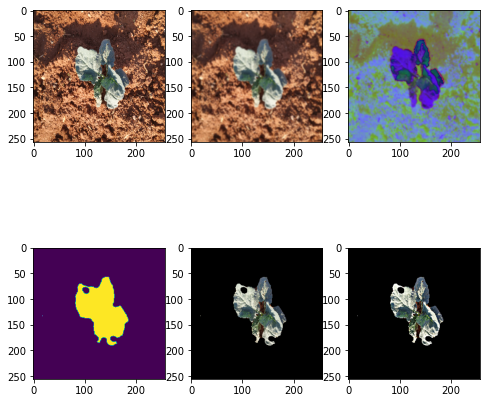

In [8]:
MIN_HUE = 0
MAX_HUE = 100
MIN_SAT = 0
MAX_SAT = 220
MIN_VAL = 0
MAX_VAL = 220

LOWER_GREEN = (MIN_HUE, MIN_SAT, MIN_VAL)
UPPER_GREEN = (MAX_HUE, MAX_SAT, MAX_VAL)
HOMOGENEOUS_SHAPE = (11, 11)
BLUR_LEVEL = (5, 5)

img = X[0]

# 1. Use gaussian blur
blur_img = cv2.GaussianBlur(img, BLUR_LEVEL, 0)

# 2. Convert to HSV image
hsv_img = cv2.cvtColor(blur_img, cv2.COLOR_BGR2HSV)  

# 3. Create mask (parameters - green color range)
mask = cv2.inRange(hsv_img, LOWER_GREEN, UPPER_GREEN)  
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, HOMOGENEOUS_SHAPE)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

# 4. Create boolean mask
b_mask = mask > 0  

# 5. Apply the mask
clear = np.zeros_like(img, np.uint8)  # Create empty image
clear[b_mask] = img[b_mask]  # Apply boolean mask to the origin image

# Show examples
plt.figure(figsize=(8, 8))
plt.subplot(2, 3, 1); plt.imshow(img)  # Show the original image
plt.subplot(2, 3, 2); plt.imshow(blur_img)  # Blur image
plt.subplot(2, 3, 3); plt.imshow(hsv_img)  # HSV image
plt.subplot(2, 3, 4); plt.imshow(b_mask)  # Boolean mask
plt.subplot(2, 3, 5); plt.imshow(clear)  # Image with removed background
plt.subplot(2, 3, 6); plt.imshow(sharpen_image(clear)) # Sharpened version of the image

## Biobliography
<a id='references'></a>
McCool, C., Perez, T., Upcroft, B., 2017. Mixtures of lightweight deep convolutional neural networks: applied to agricultural robotics. IEEE Rob. Autom. Lett. 2 (3), 1344–1351.

Milioto, A., Lottes, P., Stachniss, C., 2017. Real-time blob-wise sugar beets vs weeds classification for monitoring fields using convolutional neural networks. Proceedings of the International Conference on Unmanned Aerial Vehicles in Geomatics. Bonn, Germany.

Mohanty, S.P., Hughes, D.P., Salathé, M., 2016. Using deep learning for image-based plant disease detection. Front. Plant. Sci. 7.

Espejo-García, B., Mylonas, N., Athanasakos, L., Fountas, S., & Vasilakoglou, I. (2020). Towards weeds identification assistance through transfer learning. Comput. Electron. Agric., 171, 105306.

https://www.cs.auckland.ac.nz/courses/compsci773s1c/lectures/ImageProcessing-html/topic4.htm

## Acknowledgements
This notebook was highly inspired by the work of **Gábor Vecsei** (https://www.kaggle.com/gaborvecsei/plant-seedlings-fun-with-computer-vision)